
### Data Exploration for MovieLens 100K Dataset
============================================

This notebook explores the MovieLens dataset to understand:
- Rating distribution and patterns
- User behavior
- Item popularity
- Data sparsity


In [1]:
# ============================================================================
# Cell 1: Imports and Setup
# ============================================================================
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.data_loader import MovieLensLoader
from src.utils import (
    plot_rating_distribution,
    plot_sparsity_heatmap,
    analyze_user_behavior,
    analyze_item_popularity
)

# Styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Imports successful")


✓ Imports successful


In [2]:

# ============================================================================
# 2: Load Data
# ============================================================================
print("Loading MovieLens 100K dataset...")
loader = MovieLensLoader()

# Download if needed
loader.download_data()

# Load datasets
ratings = loader.load_ratings()
movies = loader.load_movies()
users = loader.load_users()

print("\n✓ Data loaded successfully")


Loading MovieLens 100K dataset...
Extracting dataset...
Dataset downloaded and extracted to data\raw\ml-100k
Loaded 100,000 ratings
Users: 943
Items: 1,682
Sparsity: 0.9370
Loaded 1,682 movies
Loaded 943 users

✓ Data loaded successfully


In [ ]:
# ============================================================================
# 3: Basic Statistics
# ============================================================================
print("="*70)
print("DATASET OVERVIEW")
print("="*70)

print(f"\n📊 Ratings Dataset")
print(f"   Total ratings: {len(ratings):,}")
print(f"   Unique users: {ratings['user_id'].nunique():,}")
print(f"   Unique items: {ratings['item_id'].nunique():,}")
print(f"   Rating range: {ratings['rating'].min()} - {ratings['rating'].max()}")
print(f"   Average rating: {ratings['rating'].mean():.2f}")
print(f"   Sparsity: {1 - len(ratings) / (ratings['user_id'].nunique() * ratings['item_id'].nunique()):.4f}")

print(f"\n🎬 Movies Dataset")
print(f"   Total movies: {len(movies):,}")
print(f"   Movies with genres: {movies['genres'].apply(len).gt(0).sum():,}")

print(f"\n👤 Users Dataset")
print(f"   Total users: {len(users):,}")
print(f"   Age range: {users['age'].min()} - {users['age'].max()}")
print(f"   Gender distribution:")
print(users['gender'].value_counts())

DATASET OVERVIEW

📊 Ratings Dataset
   Total ratings: 100,000
   Unique users: 943
   Unique items: 1,682
   Rating range: 1 - 5
   Average rating: 3.53
   Sparsity: 0.9370

🎬 Movies Dataset
   Total movies: 1,682
   Movies with genres: 1,682

👤 Users Dataset
   Total users: 943
   Age range: 7 - 73
   Gender distribution:
gender
M    670
F    273
Name: count, dtype: int64


In [ ]:
# ============================================================================
# 4: Sample Data
# ============================================================================
print("\n" + "="*70)
print("SAMPLE DATA")
print("="*70)

print("\n📝 Sample Ratings:")
display(ratings.head(10))

print("\n🎬 Sample Movies:")
display(movies.head(10))

print("\n👤 Sample Users:")
display(users.head(10))



SAMPLE DATA

📝 Sample Ratings:


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013



🎬 Sample Movies:


,item_id,title,release_date,genres
0,1,Toy Story (1995),01-Jan-1995,"[Animation, Children, Comedy]"
1,2,GoldenEye (1995),01-Jan-1995,"[Action, Adventure, Thriller]"
2,3,Four Rooms (1995),01-Jan-1995,[Thriller]
3,4,Get Shorty (1995),01-Jan-1995,"[Action, Comedy, Drama]"
4,5,Copycat (1995),01-Jan-1995,"[Crime, Drama, Thriller]"
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,[Drama]
6,7,Twelve Monkeys (1995),01-Jan-1995,"[Drama, Sci-Fi]"
7,8,Babe (1995),01-Jan-1995,"[Children, Comedy, Drama]"
8,9,Dead Man Walking (1995),01-Jan-1995,[Drama]
9,10,Richard III (1995),22-Jan-1996,"[Drama, War]"



👤 Sample Users:


,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213
5,6,42,M,executive,98101
6,7,57,M,administrator,91344
7,8,36,M,administrator,05201
8,9,29,M,student,01002
9,10,53,M,lawyer,90703



RATING DISTRIBUTION ANALYSIS

 Rating value counts:
rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64


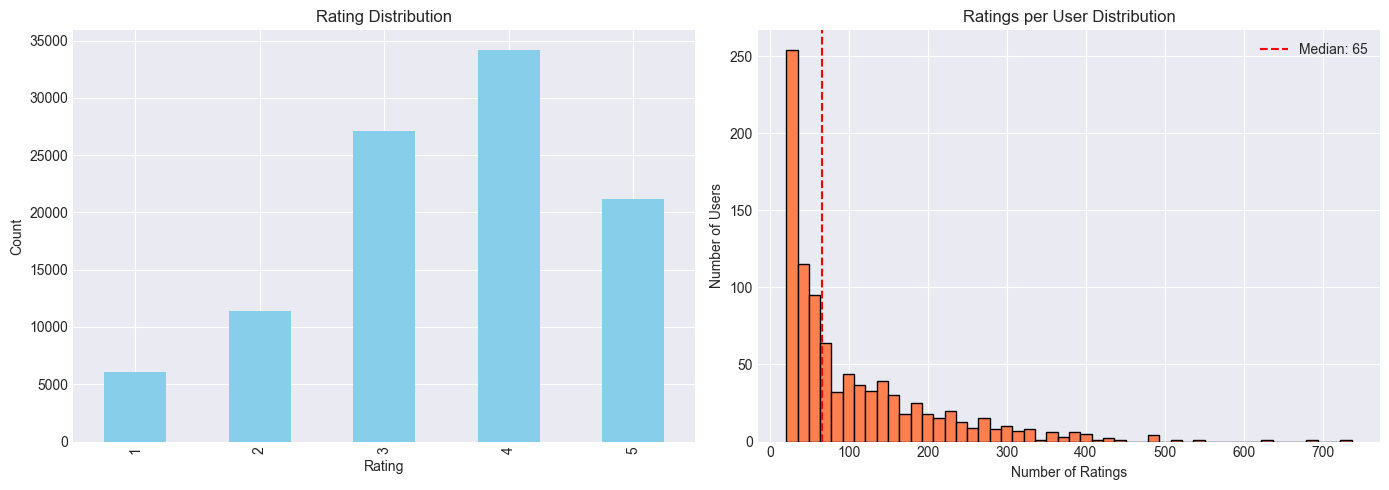


 Rating statistics:
count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


In [5]:
# ============================================================================
# 5: Rating Distribution Analysis
# ============================================================================
print("\n" + "="*70)
print("RATING DISTRIBUTION ANALYSIS")
print("="*70)

# Overall rating distribution
print("\n Rating value counts:")
print(ratings['rating'].value_counts().sort_index())

# Plot rating distribution
plot_rating_distribution(ratings)

# Rating statistics
print("\n Rating statistics:")
print(ratings['rating'].describe())



In [ ]:
# ============================================================================
# 6: User Behavior Analysis
# ============================================================================
print("\n" + "="*70)
print("USER BEHAVIOR ANALYSIS")
print("="*70)

user_stats = analyze_user_behavior(ratings)

# Display top active users
print("\n🏆 Top 10 Most Active Users:")
display(user_stats.nlargest(10, 'num_ratings'))

# Display users with extreme rating patterns
print("\n😊 Most Generous Users (highest avg rating):")
display(user_stats.nlargest(10, 'avg_rating')[['num_ratings', 'avg_rating', 'std_rating']])

print("\n😠 Most Critical Users (lowest avg rating):")
display(user_stats.nsmallest(10, 'avg_rating')[['num_ratings', 'avg_rating', 'std_rating']])



USER BEHAVIOR ANALYSIS
User Behavior Summary:
Total users: 943
Avg ratings per user: 106.0
Avg rating: 3.59

Rating Behavior Distribution:
rating_behavior
Varied             490
Consistent         451
Very Consistent      2
Very Varied          0
Name: count, dtype: int64

🏆 Top 10 Most Active Users:


,num_ratings,avg_rating,std_rating,min_rating,max_rating,num_unique_items,rating_behavior
user_id,,,,,,,
405,737,1.834464,1.345183,1,5,737,Varied
655,685,2.908029,0.732701,1,5,685,Consistent
13,636,3.097484,1.416414,1,5,636,Varied
450,540,3.864815,0.862679,1,5,540,Consistent
276,518,3.465251,1.017140,1,5,518,Varied
416,493,3.845842,1.093480,1,5,493,Varied
537,490,2.865306,0.973168,1,5,490,Consistent
303,484,3.365702,1.231295,1,5,484,Varied
234,480,3.122917,0.920366,1,5,480,Consistent



😊 Most Generous Users (highest avg rating):


,num_ratings,avg_rating,std_rating
user_id,,,
849,23,4.869565,0.344350
688,24,4.833333,0.637022
507,58,4.724138,0.767614
628,27,4.703704,0.724028
928,32,4.687500,0.692704
118,71,4.661972,0.754864
907,147,4.571429,0.682461
686,71,4.563380,0.873947
427,31,4.548387,0.767624



😠 Most Critical Users (lowest avg rating):


,num_ratings,avg_rating,std_rating
user_id,,,
181,435,1.491954,0.846138
405,737,1.834464,1.345183
445,135,1.985185,1.099424
685,20,2.050000,0.759155
774,224,2.058036,1.140855
724,85,2.164706,1.316987
206,64,2.171875,1.464443
865,66,2.287879,1.526838
626,32,2.343750,1.536846



ITEM POPULARITY ANALYSIS
Item Popularity Summary:
Total items: 1,682
Avg ratings per item: 59.5

Popularity Distribution:
popularity
Moderate        432
Niche           423
Very Popular    416
Popular         411
Name: count, dtype: int64


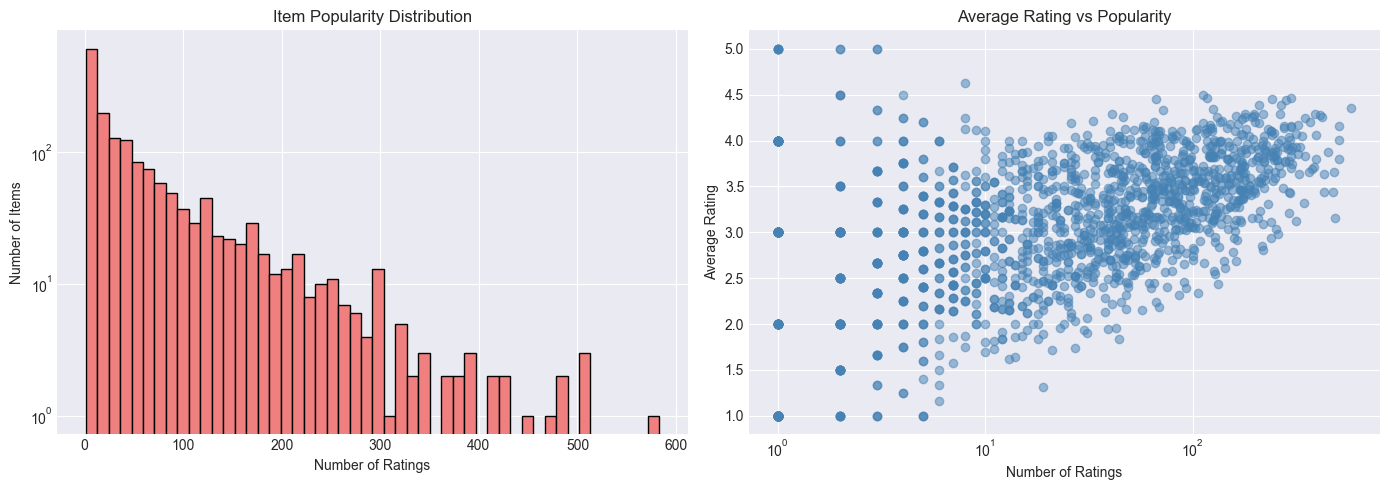


🌟 Top 10 Most Popular Movies:


,title,num_ratings,avg_rating
49,Star Wars (1977),583,4.358491
257,Contact (1997),509,3.803536
99,Fargo (1996),508,4.155512
180,Return of the Jedi (1983),507,4.007890
293,Liar Liar (1997),485,3.156701
285,"English Patient, The (1996)",481,3.656965
287,Scream (1996),478,3.441423
0,Toy Story (1995),452,3.878319
299,Air Force One (1997),431,3.631090
120,Independence Day (ID4) (1996),429,3.438228



⭐ Top 10 Highest Rated Movies (min 50 ratings):


,title,num_ratings,avg_rating
407,"Close Shave, A (1995)",112,4.491071
317,Schindler's List (1993),298,4.466443
168,"Wrong Trousers, The (1993)",118,4.466102
482,Casablanca (1942),243,4.456790
113,Wallace & Gromit: The Best of Aardman Animatio...,67,4.447761
63,"Shawshank Redemption, The (1994)",283,4.445230
602,Rear Window (1954),209,4.387560
11,"Usual Suspects, The (1995)",267,4.385768
49,Star Wars (1977),583,4.358491
177,12 Angry Men (1957),125,4.344000


In [ ]:
# ============================================================================
# 7: Item Popularity Analysis
# ============================================================================
print("\n" + "="*70)
print("ITEM POPULARITY ANALYSIS")
print("="*70)

item_stats = analyze_item_popularity(ratings)

# Merge with movie titles
item_stats_with_titles = item_stats.merge(
    movies[['item_id', 'title']], 
    left_index=True, 
    right_on='item_id'
)

print("\n🌟 Top 10 Most Popular Movies:")
display(item_stats_with_titles.nlargest(10, 'num_ratings')[
    ['title', 'num_ratings', 'avg_rating']
])

print("\n⭐ Top 10 Highest Rated Movies (min 50 ratings):")
popular_items = item_stats_with_titles[item_stats_with_titles['num_ratings'] >= 50]
display(popular_items.nlargest(10, 'avg_rating')[
    ['title', 'num_ratings', 'avg_rating']
])



GENRE ANALYSIS

📊 Genre Distribution:
Drama          725
Comedy         505
Action         251
Thriller       251
Romance        247
Adventure      135
Children       122
Crime          109
Sci-Fi         101
Horror          92
War             71
Mystery         61
Musical         56
Documentary     50
Animation       42
Western         27
Film-Noir       24
Fantasy         22
unknown          2
Name: count, dtype: int64


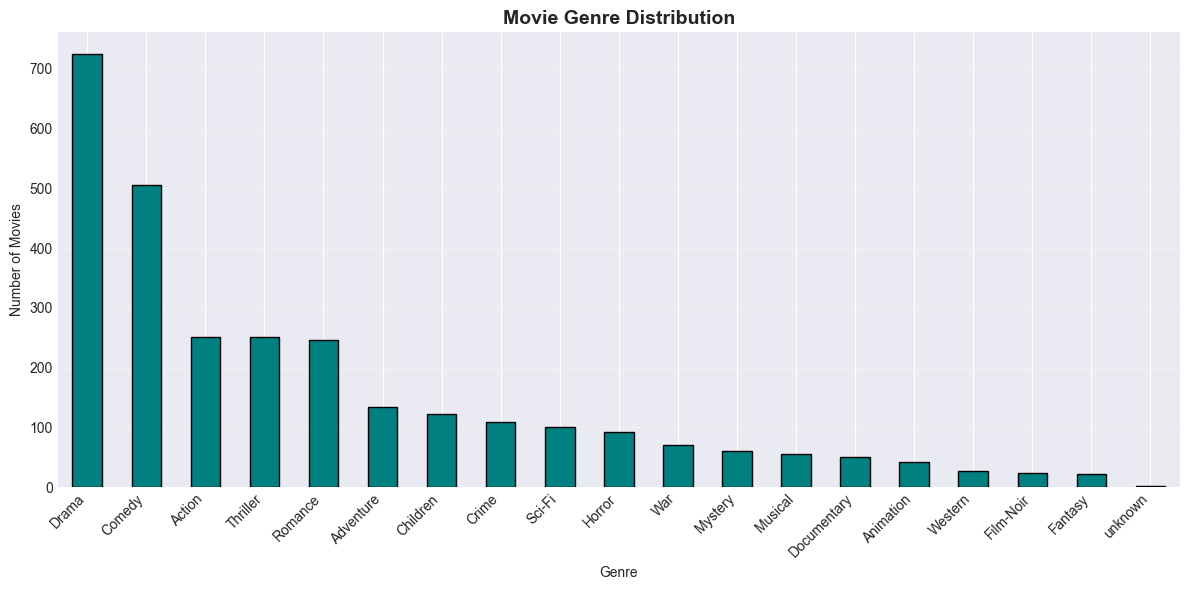


⭐ Average Rating by Genre:
Film-Noir      3.921523
War            3.815812
Drama          3.687379
Documentary    3.672823
Mystery        3.638132
Crime          3.632278
Romance        3.621705
Western        3.613269
Animation      3.576699
Sci-Fi         3.560723
Musical        3.521397
Thriller       3.509007
Adventure      3.503527
Action         3.480245
Comedy         3.394073
Children       3.353244
Horror         3.290389
Fantasy        3.215237
unknown        3.200000
dtype: float64


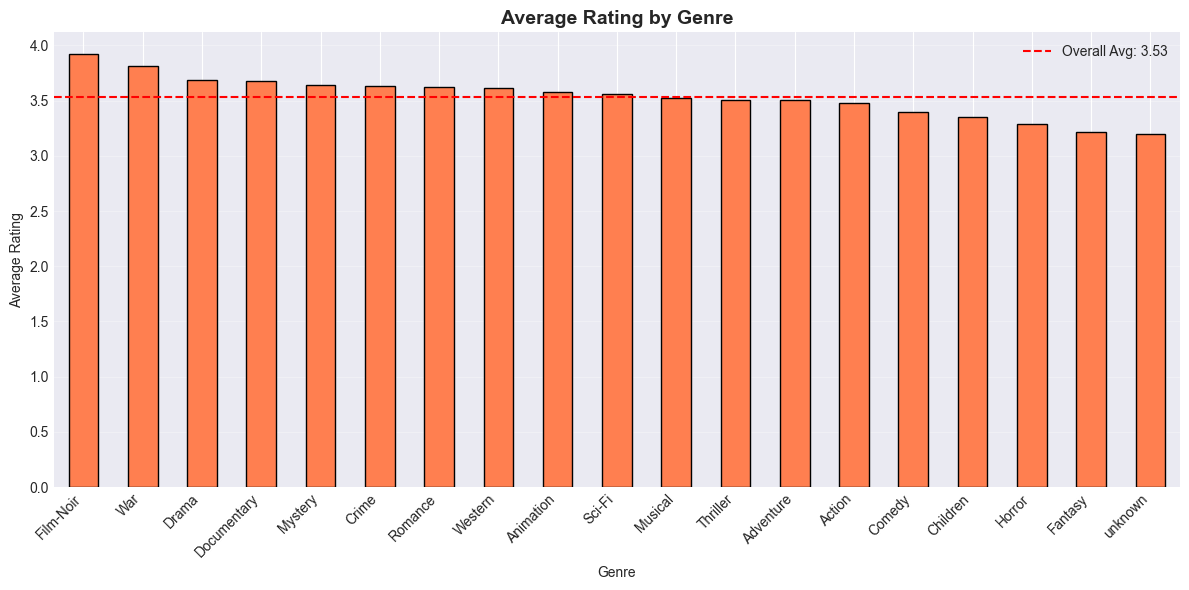

In [ ]:
# ============================================================================
# 8: Genre Analysis
# ============================================================================
print("\n" + "="*70)
print("GENRE ANALYSIS")
print("="*70)

# Extract all genres
all_genres = []
for genres_list in movies['genres']:
    all_genres.extend(genres_list)

genre_counts = pd.Series(all_genres).value_counts()

print("\n📊 Genre Distribution:")
print(genre_counts)

# Plot genre distribution
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Movie Genre Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Genre popularity by ratings
print("\n⭐ Average Rating by Genre:")
genre_ratings = {}
for idx, row in movies.iterrows():
    item_ratings = ratings[ratings['item_id'] == row['item_id']]['rating']
    for genre in row['genres']:
        if genre not in genre_ratings:
            genre_ratings[genre] = []
        genre_ratings[genre].extend(item_ratings.tolist())

genre_avg_ratings = {genre: np.mean(ratings_list) 
                     for genre, ratings_list in genre_ratings.items()}
genre_avg_ratings = pd.Series(genre_avg_ratings).sort_values(ascending=False)

print(genre_avg_ratings)

plt.figure(figsize=(12, 6))
genre_avg_ratings.plot(kind='bar', color='coral', edgecolor='black')
plt.title('Average Rating by Genre', fontsize=14, fontweight='bold')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=ratings['rating'].mean(), color='red', linestyle='--', 
            label=f'Overall Avg: {ratings["rating"].mean():.2f}')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



SPARSITY ANALYSIS

 Matrix dimensions: 943 users × 1682 items
 Total possible ratings: 1,586,126
 Actual ratings: 100,000
 Sparsity: 93.6953%
 Density: 6.3047%


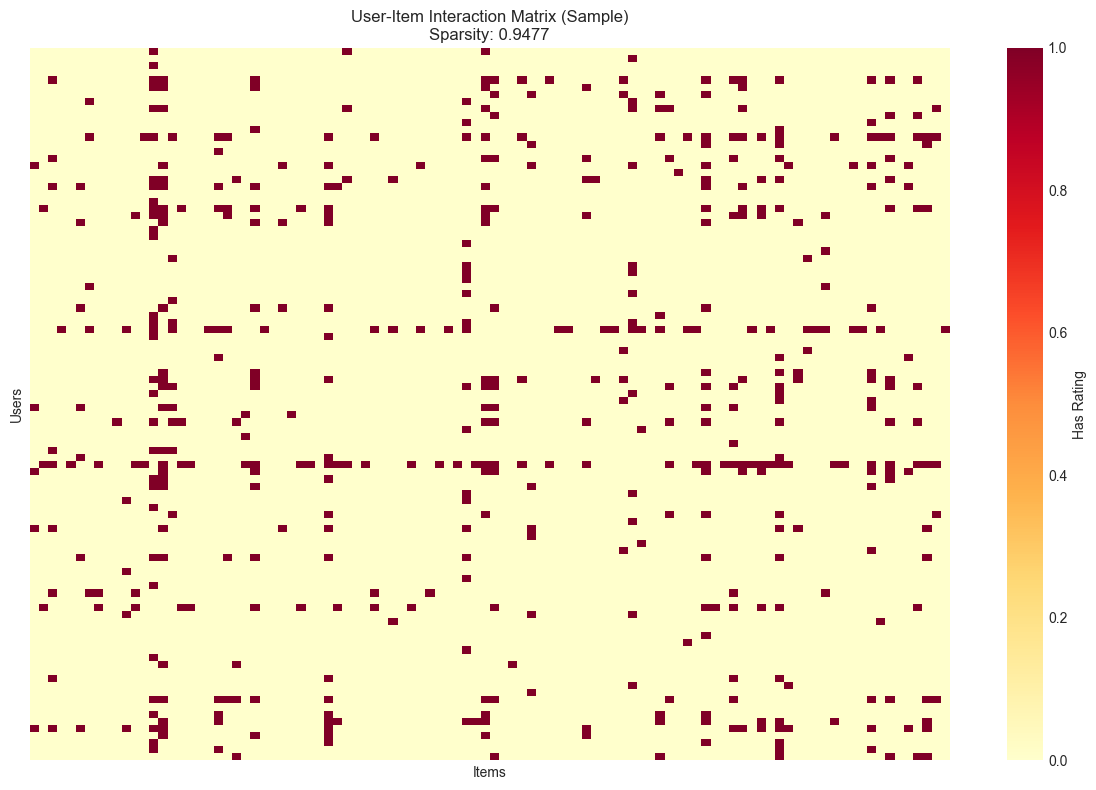

In [ ]:
# ============================================================================
# 9: Sparsity Visualization
# ============================================================================
print("\n" + "="*70)
print("SPARSITY ANALYSIS")
print("="*70)

# Calculate overall sparsity
n_users = ratings['user_id'].nunique()
n_items = ratings['item_id'].nunique()
n_ratings = len(ratings)
sparsity = 1 - (n_ratings / (n_users * n_items))

print(f"\n Matrix dimensions: {n_users} users × {n_items} items")
print(f" Total possible ratings: {n_users * n_items:,}")
print(f" Actual ratings: {n_ratings:,}")
print(f" Sparsity: {sparsity:.4%}")
print(f" Density: {1-sparsity:.4%}")

# Visualize sparsity
plot_sparsity_heatmap(ratings, sample_users=100, sample_items=100)




TEMPORAL PATTERNS

📅 Date range: 1997-09-20 03:05:10 to 1998-04-22 23:10:38


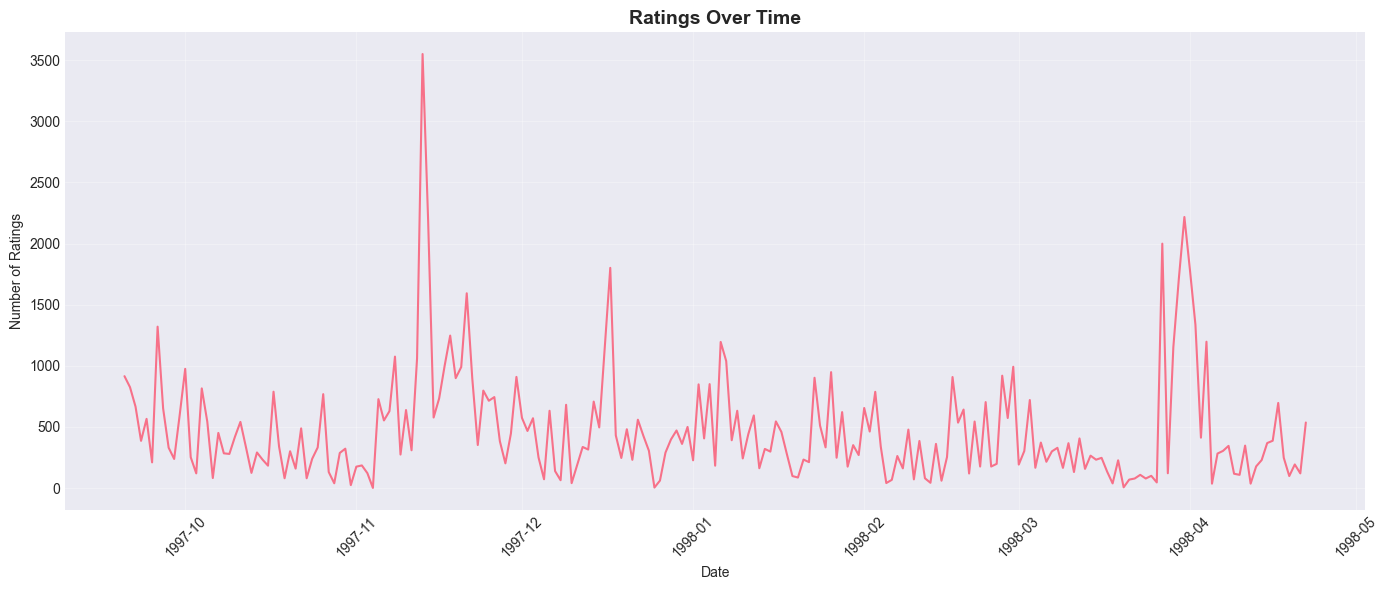

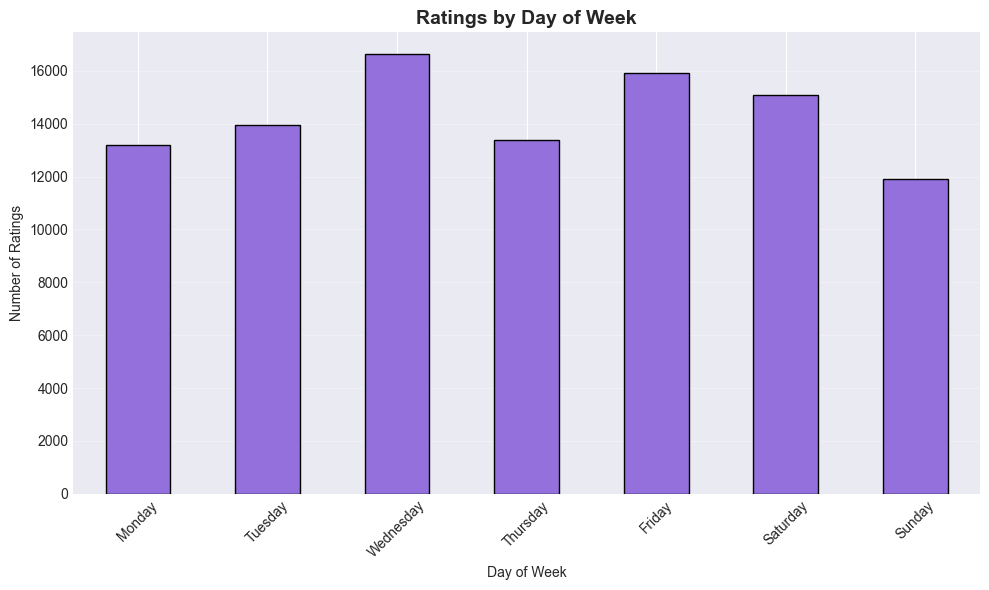

In [10]:
# ============================================================================
# 10: Temporal Patterns
# ============================================================================
print("\n" + "="*70)
print("TEMPORAL PATTERNS")
print("="*70)

# Convert timestamp to datetime
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings['date'] = ratings['datetime'].dt.date
ratings['year'] = ratings['datetime'].dt.year
ratings['month'] = ratings['datetime'].dt.month
ratings['day_of_week'] = ratings['datetime'].dt.day_name()

print(f"\n📅 Date range: {ratings['datetime'].min()} to {ratings['datetime'].max()}")

# Ratings over time
ratings_over_time = ratings.groupby('date').size()

plt.figure(figsize=(14, 6))
plt.plot(ratings_over_time.index, ratings_over_time.values, linewidth=1.5)
plt.title('Ratings Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Day of week pattern
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts = ratings['day_of_week'].value_counts().reindex(day_order)

plt.figure(figsize=(10, 6))
day_counts.plot(kind='bar', color='mediumpurple', edgecolor='black')
plt.title('Ratings by Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


COLD START ANALYSIS

 Users with < 20 ratings: 0 (0.0%)
 Items with < 5 ratings: 333 (19.8%)


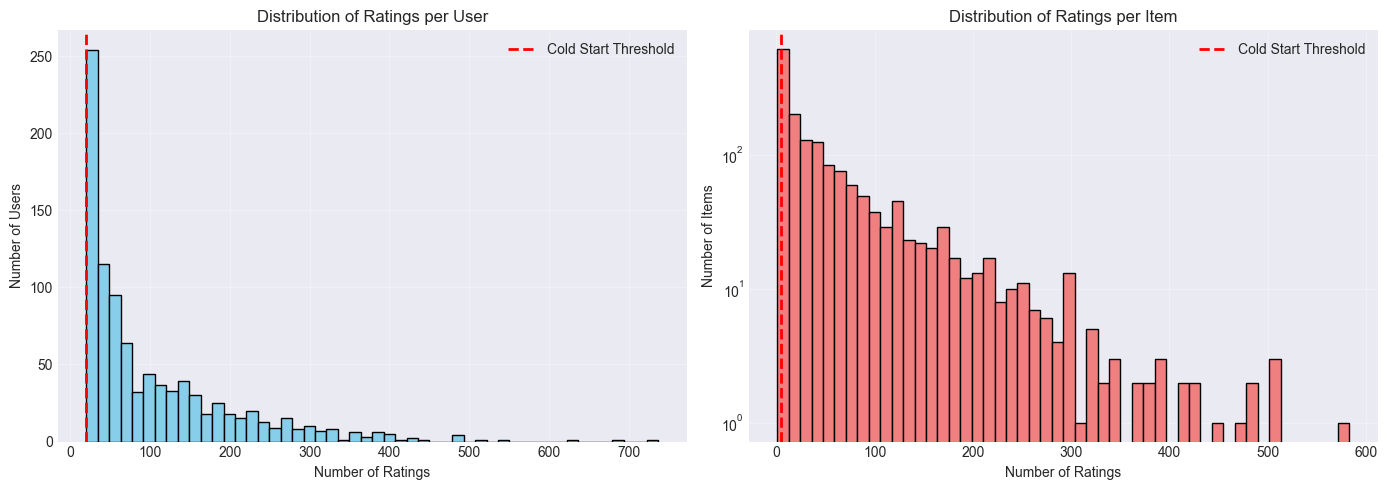

In [ ]:
# ============================================================================
# 11: Cold Start Analysis
# ============================================================================
print("\n" + "="*70)
print("COLD START ANALYSIS")
print("="*70)

# Users with few ratings (cold start users)
user_rating_counts = ratings.groupby('user_id').size()
cold_start_users = user_rating_counts[user_rating_counts < 20]

print(f"\n Users with < 20 ratings: {len(cold_start_users)} ({len(cold_start_users)/len(user_rating_counts):.1%})")

# Items with few ratings (cold start items)
item_rating_counts = ratings.groupby('item_id').size()
cold_start_items = item_rating_counts[item_rating_counts < 5]

print(f" Items with < 5 ratings: {len(cold_start_items)} ({len(cold_start_items)/len(item_rating_counts):.1%})")

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# User ratings distribution
axes[0].hist(user_rating_counts, bins=50, color='skyblue', edgecolor='black')
axes[0].axvline(x=20, color='red', linestyle='--', linewidth=2, label='Cold Start Threshold')
axes[0].set_title('Distribution of Ratings per User')
axes[0].set_xlabel('Number of Ratings')
axes[0].set_ylabel('Number of Users')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Item ratings distribution  
axes[1].hist(item_rating_counts, bins=50, color='lightcoral', edgecolor='black')
axes[1].axvline(x=5, color='red', linestyle='--', linewidth=2, label='Cold Start Threshold')
axes[1].set_title('Distribution of Ratings per Item')
axes[1].set_xlabel('Number of Ratings')
axes[1].set_ylabel('Number of Items')
axes[1].set_yscale('log')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [13]:

# ============================================================================
# 12: Key Insights Summary
# ============================================================================
print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

insights = f"""
📊 DATA CHARACTERISTICS:
   • Dataset is highly sparse ({sparsity:.2%})
   • Users rated an average of {user_rating_counts.mean():.1f} movies
   • Items received an average of {item_rating_counts.mean():.1f} ratings
   
⭐ RATING PATTERNS:
   • Most common rating: {ratings['rating'].mode()[0]}
   • Average rating: {ratings['rating'].mean():.2f}
   • Rating distribution is skewed towards positive ratings
   
❄️ COLD START CHALLENGES:
   • {len(cold_start_users)/len(user_rating_counts):.1%} of users have < 20 ratings
   • {len(cold_start_items)/len(item_rating_counts):.1%} of items have < 5 ratings
   • Content-based methods may help with item cold start
   
🎭 GENRE INSIGHTS:
   • Most common genre: {genre_counts.index[0]}
   • Highest rated genre: {genre_avg_ratings.index[0]}
   
🚀 RECOMMENDATION STRATEGY:
   • High sparsity suggests collaborative filtering may struggle
   • Hybrid approach (CF + content-based) recommended
   • Need to handle cold start for new users/items
   • Consider popularity bias in evaluation
"""

print(insights)




KEY INSIGHTS

📊 DATA CHARACTERISTICS:
   • Dataset is highly sparse (93.70%)
   • Users rated an average of 106.0 movies
   • Items received an average of 59.5 ratings

⭐ RATING PATTERNS:
   • Most common rating: 4
   • Average rating: 3.53
   • Rating distribution is skewed towards positive ratings

❄️ COLD START CHALLENGES:
   • 0.0% of users have < 20 ratings
   • 19.8% of items have < 5 ratings
   • Content-based methods may help with item cold start

🎭 GENRE INSIGHTS:
   • Most common genre: Drama
   • Highest rated genre: Film-Noir

🚀 RECOMMENDATION STRATEGY:
   • High sparsity suggests collaborative filtering may struggle
   • Hybrid approach (CF + content-based) recommended
   • Need to handle cold start for new users/items
   • Consider popularity bias in evaluation



In [14]:
# ============================================================================
# Cell 13: Save Processed Data
# ============================================================================
print("\n" + "="*70)
print("SAVING PROCESSED DATA")
print("="*70)

# Save to processed directory
import os
os.makedirs('../data/processed', exist_ok=True)

ratings.to_csv('../data/processed/ratings_with_datetime.csv', index=False)
user_stats.to_csv('../data/processed/user_statistics.csv')
item_stats.to_csv('../data/processed/item_statistics.csv')

print("\n✓ Processed data saved to data/processed/")
print("\n✅ Data exploration complete!")


SAVING PROCESSED DATA

✓ Processed data saved to data/processed/

✅ Data exploration complete!
